## Classifying YouTube videos for mood by NLP on video comments--a challenging Data Science problem

#### Our approach to this challenge was composed of multiple non-trivial steps: deciding on NLP method, preprocessing highly-varied real-world text data, applying the NLP method, and engineering additional data features, due to small video sample size.  

First, two notes: we started with no video data and had to manually label mood for 200+ videos. And we realized that this might not lead to highly accurate classification. For the learning, it was worth seeing it through, however.

#### For the NLP method, we initially considered Doc2Vec. Given the success of Word2Vec for word embedding and discovering context in text, and that Doc2Vec is built on top of it, Doc2Vec seemed a potentially good choice. Ultimately, due to time constraints, we elected to use TextBlob. See our use of it further below. 

In [ ]:
!pip install -U gensim
from gensim.models import doc2vec, Doc2Vec

#### For Python-driven data science approaches, pandas usage is almost a given. And for text analysis specifically, regular expressions can be invaluable for searching out text patterns.

In [1]:
from collections import OrderedDict
import pandas as pd
import re

Here, we look at 2 examples of csvs for our YouTube Data API v3-consumed data. Learning that consumption was a useful process in itself but is not described here. 

In [11]:
videos_df = pd.read_csv('new_videos.csv')  # note that this csv data does not have comments column
print(videos_df.shape)
videos_df.head()

(94, 3)


,video_title,video_id,moods
0,"[FREE DL] Dave East Type Beat ""Momma Workin"" (...",kQKLl6jXipQ,CHILL
1,Logic - Indica Badu ft. Wiz Khalifa [Instrumen...,-QQUaWtMW3w,HAPPY
2,【Off Vocal】Yasuha. - I Lost Your Love feat. Ha...,1QejWtVKE8s,CHILL
3,Shiva In Exile - Earth Tone (Instrumental),4zrLieLZ_i8,CHILL
4,8 Remix - Almighty ft. Varios [INSTRUMENTAL + ...,kmLvR68_nLg,CONFIDENT-SASSY


In [3]:
comments_df = pd.read_csv('new_comments.csv', encoding="utf-8")  # note no moods column
print(comments_df.shape)
comments_df.head()

(93, 2)


,video_id,comments
0,2raUmsKIG6U,"['That is some cool grafiti song, sick!', 'Dam..."
1,3XAkH0w3QLc,"['the ""jake young"" at the begining scared me l..."
2,hXe0Elz7WV8,['This is good. Definitely on favorite song li...
3,x1frIzjJv5E,['I think I would sound better at the original...
4,iPqaRRdb7eQ,[]


In [ ]:
# full_videos_df = pd.merge(videos_df, comments_df, on='video_id')
# use above line as example, if need to merge new_comments and new_videos csv's

### Preprocessing the comments data

#### Nothing like working with text to learn (or re-learn) that computing involves symbols that are encoded in different sets, eg, Unicode and utf-8. Joel Spolsky has a classic post [here](https://www.joelonsoftware.com/2003/10/08/the-absolute-minimum-every-software-developer-absolutely-positively-must-know-about-unicode-and-character-sets-no-excuses/). And Wikipedia has a useful entry [here](https://en.wikipedia.org/wiki/Unicode_and_HTML).

Here we can see comments data consumed from the YouTube API.

In [ ]:
# Examine the raw comments for the first video
first_vid_comments = comments_df.comments.values[0]
first_vid_comments  # NOTE: this whole object is a string; change it to a list with strings inside

In [ ]:
# Tried various operations on first video comments
# Create a list object of first video comments by splitting on "\', " -- not successful

In [ ]:
# Let's see the raw comments for the second video
second_vid_comments = comments_df.comments.values[1]
second_vid_comments

This code did not ultimately get used for preprocessing.

In [ ]:
# Study all comments for all videos
# Based on methods from aws-sagemaker-python-notebook [not yet updated on github]
all_comments = []
all_comments_dict = {}
for comment_group in list(comments_df.comments):
    comment_group = comment_group.replace('[', '')
    comment_group = comment_group.replace(']', '')
    comment_group = comment_group.replace("'", '')
    all_comments.append(comment_group)
    
print('length of all_comments is:', len(all_comments))
print(all_comments[:2])

But **this** function became the comments preprocessing workhorse for our workflow.

In [4]:
# Convert text to lower-case, do several char replacements, and create list by splitting comments string
# Create a function to do this when applied to all values in df's comments column

def normalize_text(comment_group):
    norm_comment_group = comment_group.lower()
    norm_comment_group = re.sub(r"([\.\",\(\)!\?;:])", " \\1 ", norm_comment_group)
    norm_comment_group = norm_comment_group.replace('\\n', ', ')
    norm_comment_group = norm_comment_group.replace('"', "\'")
    while "\'" in norm_comment_group:
        norm_comment_group = norm_comment_group.replace("\'", '')
    norm_comment_group = norm_comment_group.replace('[', '')
    norm_comment_group = norm_comment_group.replace(']', '')
    return norm_comment_group

# Apply normalize_text function to all comments column values

comments_df.comments = comments_df.comments.apply(lambda x: normalize_text(x))

Note how the words now appear more like typewritten text.

In [5]:
comments_df.comments.values[:2]

array(['that is some cool grafiti song ,  sick !  ,  damn this is dope ,  i miss the 90s ,  nice beat and cuts man ,  unfortunately they faded so early .  ,  very nice beat bra ,  can you feel it can you feel it can you feeeeel itttt ,  this is super golden age hip hop ,  but still so atmospheric with that string sample !  !  i just dropped a new vid on my channel would love to hear the opinion of a true artist like you over there !  love this beat tho bro !  ,  gj /goodjob !  ,  se puede sacar una super improvisacion buen beat ,    hello .  i want to use ur music for a dance project but i cant find you on facebook ,  and also not on soundcloud .  how can i get your music ?  thank you   ,    whos down to start a rap group   ,  you bouta get the cred for some slick shit bro this beat is fucking absurd ,    its ok if not   ,  can i use this brother ?  ,  hola man queria saber si podia utilizar este  beat para un tema que tengo pensado  ( se llama   mientras suenan las sirenas  )  y es ju

In [ ]:
# The fourth video, with id iPqaRRdb7eQ, has no comments. 
comments_df.comments.values[4]

### Trying TextBlob for NLP

In [6]:
!pip install textblob
from textblob import TextBlob

In [17]:
from collections import Counter
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from statistics import mean
import numpy as np

In [8]:
# Tags can be removed if in nltk stopwords
# To be able to iterate over stopwords, have to put them in an iterable

def tags_filter_stopwords(tags):
    stop_eng = set(stopwords.words('english'))
    stop_esp = set(stopwords.words('spanish'))
    stop_fr = set(stopwords.words('french'))
    stop_de = set(stopwords.words('german'))
    # no stopwords available for Chinese or Japanese
    stop_four = stop_eng.union(stop_esp.union(stop_fr.union(stop_de)))
    tags_list = []
    for tag in tags:
        if tag[0] not in stop_four:
            tags_list.append(tag)
    return tags_list


# Also want to know which parts of speech TextBlob codes are most common among the tags
def top_three_tag_codes(tags):
    """Receives list of tags; returns 3 most common TextBlob parts-of-speech codes"""
    # Recall that each TextBlob tag is a tuple of a word and a TextBlob part-of-speech code
    speech_parts_list = []
    for tag in tags:
        speech_parts_list.append(tag[1])
    c = Counter(speech_parts_list)
    print(c.most_common(3), 'len(c.most_common(3)) is:', len(c.most_common(3)))
    # note that there may only be one most common tag
    return c.most_common(3)  # returns a list of 2-item tuple[s] with code and count for code in tags

In [137]:
# Add two new columns to comments_df: one each for TextBlob polarity mean and subjectivity mean
# Want to add other new columns also based on tags:
# one column for each of the top 3, and one column for the count in comments for each of the top 3 

tags_columns = ['polarity_mean', 'subjectivity_mean', 'tags', 'tags_count', 'top_tag', 'top_tag_count',
                'second_tag', 'second_tag_count', 'third_tag', 'third_tag_count']
analysis_df = pd.concat([comments_df, pd.DataFrame(columns=tags_columns)], axis=1)

analysis_df = pd.merge(analysis_df, videos_df, on='video_id')
cols = analysis_df.columns.to_list()
cols = [cols[0]] + [cols[11]] + [cols[1]] + cols[2:11] + [cols[-1]]
analysis_df = analysis_df[cols]

In [138]:
analysis_df.head()

,video_id,third_tag_count,comments,polarity_mean,subjectivity_mean,tags,tags_count,top_tag,top_tag_count,second_tag,second_tag_count,third_tag,moods
0,2raUmsKIG6U,NaN,"that is some cool grafiti song , sick ! , d...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHILL
1,3XAkH0w3QLc,NaN,the jake young at the begining scared me l...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHILL
2,hXe0Elz7WV8,NaN,this is good . definitely on favorite song li...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CONFIDENT-SASSY
3,x1frIzjJv5E,NaN,i think i would sound better at the original s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHILL
4,iPqaRRdb7eQ,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHILL


In [139]:
# Drop rows where there are no comments
analysis_df = analysis_df[analysis_df.comments != '']
analysis_df.shape

(86, 13)

In [140]:
# Add TextBlob mean polarity, mean subjectivity, and tags features for all comments for each video
# Write functions to do each of the following:
# 1) run TextBlob on comments; 2) populate polarity_mean, subjectivity_mean, and tags values

def get_blob(comments):
    """Use with one video's comments at a time."""
    comments = normalize_text(comments)
    blob = TextBlob(comments)
    # tags = tags_filter_stopwords(blob.tags)  # this is functional code but may decrease ML classif. accuracy
    tags = blob.tags
    tags_count = len(tags)
    top_tags = top_three_tag_codes(tags)  # this is a list of 2-item tuple[s]
    top_tag = top_tags[0][0]
    top_tag_count = top_tags[0][1]
    if len(top_tags) < 2:
        second_tag = np.nan
        second_tag_count = 0
        third_tag = np.nan
        third_tag_count = 0
    elif len(top_tags) == 2:
        second_tag = top_tags[1][0]
        second_tag_count = top_tags[1][1]
        third_tag = np.nan
        third_tag_count = 0
    elif len(top_tags) > 2:
        # 3-item list of tuples with each top code and its count
        second_tag = top_tags[1][0]
        second_tag_count = top_tags[1][1]
        third_tag = top_tags[2][0]
        third_tag_count = top_tags[2][1]
    polarity_list = []
    subjectivity_list = []
    for sentence in blob.sentences:
        polarity = sentence.sentiment.polarity
        subjectivity = sentence.sentiment.subjectivity
        if polarity !=0 :
            polarity_list.append(polarity)
        if subjectivity !=0 :
            subjectivity_list.append(subjectivity)
    if len(polarity_list) == 0:
        polarity_list.append(0)
    if len(subjectivity_list) == 0:
        subjectivity_list.append(0)
    # print(top_tag, second_tag)
    return (mean(polarity_list), mean(subjectivity_list), tags, tags_count, top_tag, top_tag_count,
            second_tag, second_tag_count, third_tag, third_tag_count)

def populate_blob_columns(df, comms):
    """Use to fill the polarity_mean, subjectivity_mean, and tags columns."""
    """This was first used successfully on analysis_df."""
    (polarity_mean, subjectivity_mean, tags, tags_count, top_tag, top_tag_count,
            second_tag, second_tag_count, third_tag, third_tag_count) = get_blob(comms)
    df.loc[(df.comments == comms), 'polarity_mean'] = polarity_mean
    df.loc[(df.comments == comms), 'subjectivity_mean'] = subjectivity_mean
    df.loc[(df.comments == comms), 'tags'] = [tags]
    df.loc[(df.comments == comms), 'tags_count'] = tags_count
    df.loc[(df.comments == comms), 'top_tag'] = top_tag
    df.loc[(df.comments == comms), 'top_tag_count'] = top_tag_count
    df.loc[(df.comments == comms), 'second_tag'] = second_tag
    df.loc[(df.comments == comms), 'second_tag_count'] = second_tag_count
    df.loc[(df.comments == comms), 'third_tag'] = third_tag
    df.loc[(df.comments == comms), 'third_tag_count'] = third_tag_count
    
    
for comments in analysis_df.comments.values:
    populate_blob_columns(analysis_df, comments)

[('NN', 81), ('JJ', 32), ('DT', 18)] len(c.most_common(3)) is: 3
[('NN', 107), ('JJ', 50), ('DT', 43)] len(c.most_common(3)) is: 3
[('NN', 23), ('JJ', 11), ('IN', 6)] len(c.most_common(3)) is: 3
[('NN', 19), ('DT', 16), ('JJ', 9)] len(c.most_common(3)) is: 3
[('NN', 8)] len(c.most_common(3)) is: 1
[('NN', 9), ('JJ', 4), ('IN', 2)] len(c.most_common(3)) is: 3
[('NN', 5), ('VBD', 1), ('PRP', 1)] len(c.most_common(3)) is: 3
[('NN', 25), ('DT', 11), ('RB', 8)] len(c.most_common(3)) is: 3
[('NN', 245), ('IN', 118), ('DT', 96)] len(c.most_common(3)) is: 3
[('NN', 168), ('IN', 83), ('VB', 83)] len(c.most_common(3)) is: 3
[('NN', 82), ('DT', 37), ('IN', 36)] len(c.most_common(3)) is: 3
[('NN', 149), ('PRP', 122), ('JJ', 94)] len(c.most_common(3)) is: 3
[('NN', 304), ('DT', 120), ('JJ', 106)] len(c.most_common(3)) is: 3
[('NN', 11), ('FW', 6), ('NNS', 4)] len(c.most_common(3)) is: 3
[('NN', 6), ('VBP', 3), ('DT', 3)] len(c.most_common(3)) is: 3
[('NN', 208), ('IN', 87), ('JJ', 66)] len(c.most_c

In [141]:
# Check how df looks
print(analysis_df.shape)
print(analysis_df.isna().sum().sum())
analysis_df.head()

(86, 13)
7


,video_id,third_tag_count,comments,polarity_mean,subjectivity_mean,tags,tags_count,top_tag,top_tag_count,second_tag,second_tag_count,third_tag,moods
0,2raUmsKIG6U,18,"that is some cool grafiti song , sick ! , d...",0.252059,0.652953,"[(that, DT), (is, VBZ), (some, DT), (cool, JJ)...",246,NN,81,JJ,32,DT,CHILL
1,3XAkH0w3QLc,43,the jake young at the begining scared me l...,0.45385,0.707216,"[(the, DT), (jake, NN), (young, JJ), (at, IN),...",517,NN,107,JJ,50,DT,CHILL
2,hXe0Elz7WV8,6,this is good . definitely on favorite song li...,0.625,0.733333,"[(this, DT), (is, VBZ), (good, JJ), (definitel...",72,NN,23,JJ,11,IN,CONFIDENT-SASSY
3,x1frIzjJv5E,9,i think i would sound better at the original s...,0.2875,0.811389,"[(i, JJ), (think, VBP), (i, NNS), (would, MD),...",80,NN,19,DT,16,JJ,CHILL
5,qL034NgzGxY,0,zoo heev li kho siab heev zoo mloog,0,0,"[(zoo, NN), (heev, NN), (li, NN), (kho, NN), (...",8,NN,8,NaN,0,NaN,SAD


#### Apply ML

In [142]:
# First normalize the data by multiplying polarity_mean and subjectivity_mean each by 100
analysis_df.polarity_mean *= 100
analysis_df.subjectivity_mean *= 100

# Verify that the values have been scaled by 100
analysis_df.polarity_mean.values[:2]

array([25.205943362193363, 45.38504088504089], dtype=object)

In [129]:
# What if, instead of 0's for polarity_mean and subjectivity_mean,
# the 0's were replaced by 50? Every song has some polarity and subjectivity, right?

analysis_df.polarity_mean = analysis_df.polarity_mean.replace(0, 50)
analysis_df.subjectivity_mean = analysis_df.subjectivity_mean.replace(0, 50)

In [143]:
analysis_df.tail()

,video_id,third_tag_count,comments,polarity_mean,subjectivity_mean,tags,tags_count,top_tag,top_tag_count,second_tag,second_tag_count,third_tag,moods
87,E5SWz3suC2o,17,"its yung charc , this beat is pure comethazin...",26.36,47.4698,"[(its, PRP$), (yung, NN), (charc, NN), (this, ...",687,NN,337,JJ,275,PRP,CHILL
88,Vt6adjjww9g,3,https : //www . youtube . com/watch ? v=rak5d-...,0,0,"[(https, NN), (//www, NN), (youtube, NN), (com...",19,NN,7,JJ,3,FW,CONFIDENT-SASSY
89,E6dqEdx3Org,2,"oh my god dude thank you bro thank god bro , ...",0,0,"[(oh, UH), (my, PRP$), (god, JJ), (dude, NN), ...",24,NN,13,JJ,2,PRP,CONFIDENT-SASSY
90,-SzIFcsrFTk,54,"this, is, a, beautiful, heavenly , epic, m a s...",37.2667,72.9611,"[(this, DT), (is, VBZ), (a, DT), (beautiful, N...",552,NN,117,IN,61,DT,HAPPY
91,ZgO2pN2xmVU,22,"how wiz not gonna give bobby the laugh ! ? , ...",26.4432,47.553,"[(how, WRB), (wiz, JJ), (not, RB), (gon, VBG),...",217,NN,62,JJ,24,DT,CONFIDENT-SASSY


In [144]:
# Next, define features for X, and target for y
# And split data into training and test sets

X = analysis_df[['polarity_mean', 'subjectivity_mean', 'tags_count', 'top_tag_count',
                 'second_tag_count', 'third_tag_count']]
y = analysis_df.moods

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)

In [118]:
# Fit a model - this is a multiclass classification, supervised machine learning problem
# because there are 6 moods in the df moods column

# Try a simple model first - KNN classifier
from sklearn.neighbors import KNeighborsClassifier

In [145]:
knn = KNeighborsClassifier(n_neighbors=7).fit(X_train, y_train)

In [146]:
# Check accuracy of the model, using X_test and y_test
accuracy = knn.score(X_test, y_test)
print('accuracy is:', accuracy)

accuracy is: 0.0


In [26]:
# Now will try a more complex model - Random Forest classification
from sklearn.ensemble import RandomForestClassifier

In [27]:
RFC = RandomForestClassifier(n_estimators=25, max_depth=2, random_state=7)

In [147]:
RFC.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
            oob_score=False, random_state=7, verbose=0, warm_start=False)

In [148]:
# See the respective importance for each of the features in X
print(RFC.feature_importances_)

[0.2584825  0.16334598 0.12495001 0.19138555 0.11437989 0.14745607]


In [149]:
# Check accuracy of the model
accuracy = RFC.score(X_test, y_test)
print('accuracy is:', accuracy)

accuracy is: 0.13636363636363635


In [ ]:
# Send a csv
analysis_df.to_csv('model_training.csv')

#### Sandbox for working with new comments, TextBlob, other

In [ ]:
# Let's work with the first video's comments, to start

blob = TextBlob(comments_df.comments.values[0])

In [ ]:
# See if tags can be gotten for the first video's comments
print(len(blob.tags))
blob.tags[:3]

In [ ]:
tags_filter_stopwords(blob.tags)

In [ ]:
# Verify correct functioning of top_three_tag_codes
top_three_tag_codes(blob.tags)

In [ ]:
# Exploring sentiment delivered by TextBlob, on 15 May 2019

polarity_list = []
subjectivity_list = []
for sentence in blob.sentences:
    print('polarity and subjectivity for this sentence are:', sentence.sentiment)
    polarity = sentence.sentiment.polarity
    subjectivity = sentence.sentiment.subjectivity
    if polarity !=0 :
        polarity_list.append(polarity)
    if subjectivity !=0 :
        subjectivity_list.append(subjectivity)
print('polarity_list is:', polarity_list, '\n', 'subjectivity_list is:', subjectivity_list)

In [ ]:
# Looking at a new comments csv from 16 May 2019

comments1_df = pd.read_csv('new_comments1.csv')
comments1_df.head()
len(comments1_df.loc[comments1_df.comments == '[]'])

In [ ]:
get_blob(comments_df.comments.values[0])

In [ ]:
type(comments_df.comments[4])
# get_blob(comments_df.comments[4])

In [ ]:
get_blob(comments_df.comments[5])

In [ ]:
'not' in stop_eng

In [31]:
# Want to try an unsupervised approach to grouping the videos
# Given: videos are in df with their associated comments, which have been processed,
# and polarity, subjectivity, and tags features are also available

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [39]:
kmc_df = analysis_df[['subjectivity_mean', 'top_tag_count']]

In [40]:
kmeans = KMeans(n_clusters=6).fit(kmc_df)

In [41]:
centroids = kmeans.cluster_centers_
print('centroids are:\n', centroids)

centroids are:
 [[ 14.22828283  10.46666667]
 [ 59.86435437 181.53333333]
 [ 57.         833.        ]
 [ 73.23741848  23.82758621]
 [ 62.01157974  84.14285714]
 [ 41.59534043 365.2       ]]


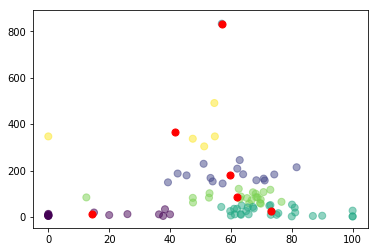

In [43]:
plt.scatter(kmc_df['subjectivity_mean'], kmc_df['top_tag_count'], c=kmeans.labels_.astype(float),
            s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50);

In [150]:
# New data in - 20 May 2019, 1:40PM PST

large_videos_df = pd.read_csv('new_videos_2.csv')
lg_videos_comments_df = pd.read_csv('video_comments_2.csv')
lg_videos_descrips_df = pd.read_csv('video_descriptions_2.csv')

In [152]:
print(large_videos_df.shape)
print(lg_videos_comments_df.shape)
lg_videos_descrips_df.shape

(578, 4)
(586, 3)


(595, 5)

In [155]:
comments_descrips_df = pd.merge(lg_videos_comments_df, lg_videos_descrips_df,
                                how='inner', on=['video_id'])

In [156]:
videos_all_df = pd.merge(large_videos_df, comments_descrips_df,
                         how='inner', on=['video_id'])

In [159]:
videos_all_df = videos_all_df.drop(['id_y', 'video_title_y'], axis=1)

In [161]:
videos_all_df = videos_all_df.rename(columns={'video_title_x': 'video_title',
                                              'id_x': 'id'})
videos_all_df.head()

,video_title,video_id,moods,labeled,id,comments,video_description,predicted_moods
0,Disfigure - Hollah! FREE DUBSTEP Creative Comm...,ZzsWXK-MKME,HAPPY,t,524,[],♫ Please Subscribe to Creative Commons Music F...,NaN
1,♩♫ Dramatic Apocalyptic Music ♪♬ - The Wastela...,5eAalHA1bAc,CHILL,t,56,"['Linda composição!!!', 'Who is here from real...",INSTAGRAM! : https://instagram.com/rossbugden/...,NaN
2,Zend Music | Mendum - Elysium [NCS Release] | ...,sCfVL8mULEA,ANGRY,t,497,['Zend Music | Mendum - Elysium [NCS Release] ...,Zend Music | Mendum - Elysium [NCS Release] | ...,NaN
3,Zend Music | JPB - High [NCS Release] | Free M...,sCcGq9g5iA4,HAPPY,t,501,['Zend Music | JPB - High [NCS Release] | Free...,Zend Music | JPB - High [NCS Release] | Free M...,NaN
4,Nostalgy - (No Copyright Music) Sad Cinematic ...,zViXwVZpWqY,SAD,t,442,['Download this music track: http://bit.ly/2QC...,Download Music: http://bit.ly/2QC9e3K (No Copy...,NaN


In [162]:
videos_all_df.shape

(578, 8)

In [176]:
len(videos_all_df[videos_all_df.comments=='[]'])

211

In [170]:
labeled_videos_df = videos_all_df[videos_all_df.labeled=='t']

In [177]:
labeled_videos_df.to_csv('labeled_videos.csv')

In [171]:
unlabeled_videos_df = videos_all_df[videos_all_df.labeled !='t']

In [175]:
unlabeled_videos_df.tail()

,video_title,video_id,moods,labeled,id,comments,video_description,predicted_moods
573,Jordan Schor Marvin Divine - Want It All (Bas...,w2XlLDlge2c,HAPPY,NaN,1113,['Mantap gan music nya'],"Jangan Lupa LIKE, SHARE & SUBSCRIBE ^_^\n\n\nN...",NaN
574,Cinematic Motivational - Telifsiz Müzik - No ...,RpGcUrP6Qzs,HAPPY,NaN,1114,[],Download Music: http://bit.ly/2Gsq6H3 (No Copy...,NaN
575,Snow Falling Animation | 4K |With Royalty Free...,2d3vBG8VfiM,HAPPY,NaN,1115,[],Snow Falling Animation | 4K | With Royalty Fre...,NaN
576,DRW – Programmer [House] from Royalty Free Pla...,l3vEtwBRGPE,HAPPY,NaN,1116,"['Fleeting tune, jams!!!', 'I am glad that I f...",Royalty Free Planet is home to the best qualit...,NaN
577,FUTURE SHOCK - No Copyright Music - Elelectro ...,RNd5JYLL-z0,HAPPY,NaN,1117,"['Bella Brother!', 'Inquietantemente, ipnotica...",Elelectro dance music FREE DOWNLOAD\nno copyri...,NaN


In [178]:
unlabeled_videos_df.to_csv('unlabeled_videos.csv')

In [103]:
tags_columns = ['polarity_mean', 'subjectivity_mean', 'tags', 'tags_count', 'top_tag', 'top_tag_count',
                'second_tag', 'second_tag_count', 'third_tag', 'third_tag_count']
lg_videos_comments_df = pd.concat([lg_videos_comments_df, pd.DataFrame(columns=tags_columns)], axis=1)

In [104]:
lg_videos_comments_df.shape

(539, 14)

In [105]:
lg_videos_comments_df = lg_videos_comments_df[lg_videos_comments_df.comments != '[]']

In [106]:
lg_videos_comments_df.shape

(337, 14)

In [107]:
for comments in lg_videos_comments_df.comments.values:
    populate_blob_columns(lg_videos_comments_df, comments)

[('NN', 43), ('JJ', 19), ('IN', 14)] len(c.most_common(3)) is: 3
[('NN', 40), ('JJ', 10), ('FW', 5)] len(c.most_common(3)) is: 3
[('NN', 180), ('JJ', 51), ('FW', 38)] len(c.most_common(3)) is: 3
[('NN', 43), ('JJ', 16), ('DT', 9)] len(c.most_common(3)) is: 3
[('NN', 65), ('JJ', 31), ('DT', 20)] len(c.most_common(3)) is: 3
[('NN', 117), ('IN', 61), ('DT', 54)] len(c.most_common(3)) is: 3
[('NN', 35), ('JJ', 9), ('VB', 6)] len(c.most_common(3)) is: 3
[('NNP', 19), ('NN', 10), ('CD', 5)] len(c.most_common(3)) is: 3
[('NN', 120), ('NNP', 37), ('IN', 27)] len(c.most_common(3)) is: 3
[('NN', 168), ('IN', 83), ('VB', 83)] len(c.most_common(3)) is: 3
[('NN', 187), ('JJ', 43), ('FW', 39)] len(c.most_common(3)) is: 3
[('NN', 616), ('JJ', 177), ('FW', 109)] len(c.most_common(3)) is: 3
[('NN', 11), ('PRP', 7), ('VB', 5)] len(c.most_common(3)) is: 3
[('NN', 165), ('JJ', 52), ('FW', 49)] len(c.most_common(3)) is: 3
[('NN', 84), ('FW', 20), ('JJ', 15)] len(c.most_common(3)) is: 3
[('NN', 43), ('JJ', 

[('NN', 54), ('JJ', 17), ('DT', 7)] len(c.most_common(3)) is: 3
[('NN', 5), ('JJ', 3), ('DT', 2)] len(c.most_common(3)) is: 3
[('NN', 47), ('IN', 29), ('DT', 22)] len(c.most_common(3)) is: 3
[('NN', 63), ('DT', 27), ('JJ', 26)] len(c.most_common(3)) is: 3
[('NN', 7), ('JJ', 4), ('IN', 3)] len(c.most_common(3)) is: 3
[('NN', 7), ('NNS', 3), ('IN', 3)] len(c.most_common(3)) is: 3
[('NN', 11), ('JJ', 9), ('RB', 8)] len(c.most_common(3)) is: 3
[('NN', 105), ('JJ', 50), ('IN', 42)] len(c.most_common(3)) is: 3
[('JJ', 3), ('NN', 2), ('VB', 2)] len(c.most_common(3)) is: 3
[('NN', 78), ('JJ', 25), ('NNS', 10)] len(c.most_common(3)) is: 3
[('NN', 9), ('PRP$', 3), ('NNS', 2)] len(c.most_common(3)) is: 3
[('NN', 5), ('VB', 3), ('JJ', 3)] len(c.most_common(3)) is: 3
[('NN', 12)] len(c.most_common(3)) is: 1
[('NN', 3), ('VB', 3), ('NNS', 2)] len(c.most_common(3)) is: 3
[('NN', 217), ('JJ', 47), ('NNP', 41)] len(c.most_common(3)) is: 3
[('NN', 16), ('JJ', 6), ('DT', 5)] len(c.most_common(3)) is: 3
[

[('NN', 47), ('DT', 20), ('IN', 17)] len(c.most_common(3)) is: 3
[('NN', 42), ('JJ', 15), ('IN', 10)] len(c.most_common(3)) is: 3
[('NN', 5), ('JJ', 4), ('DT', 2)] len(c.most_common(3)) is: 3
[('NN', 4), ('PRP$', 2), ('JJ', 2)] len(c.most_common(3)) is: 3
[('NN', 43), ('RB', 9), ('VB', 9)] len(c.most_common(3)) is: 3
[('NN', 6), ('NNS', 2), ('VB', 2)] len(c.most_common(3)) is: 3
[('NN', 7), ('VB', 3), ('MD', 2)] len(c.most_common(3)) is: 3
[('JJ', 1)] len(c.most_common(3)) is: 1
[('NN', 77), ('JJ', 20), ('VB', 20)] len(c.most_common(3)) is: 3
[('NN', 7), ('IN', 4), ('DT', 2)] len(c.most_common(3)) is: 3
[('NN', 9), ('NNP', 6), ('JJ', 4)] len(c.most_common(3)) is: 3
[('NN', 117), ('IN', 33), ('VB', 27)] len(c.most_common(3)) is: 3
[('NN', 60), ('DT', 14), ('IN', 13)] len(c.most_common(3)) is: 3
[('NN', 61), ('DT', 27), ('IN', 22)] len(c.most_common(3)) is: 3
[('NN', 79), ('IN', 18), ('VB', 15)] len(c.most_common(3)) is: 3
[('NN', 81), ('IN', 25), ('PRP', 23)] len(c.most_common(3)) is: 3

In [125]:
print(lg_videos_comments_df.shape)
lg_videos_comments_df.head()
lg_videos_comments_df.tags_count.describe()

(337, 14)


count     337
unique    182
top        14
freq       13
Name: tags_count, dtype: int64

#### End Sandbox

### Creating a Doc2Vec NLP model

In [ ]:
# make a Doc2Vec TaggedDocument for each video's comments;
# append each of those Doc2Vec TaggedDocuments to a "sentences" list;
# create: model = models.Doc2Vec(alpha=.025, min_alpha=.025, min_count=1);
# call: model.build_vocab(sentences);
# train model: for epoch in range(int):... model.train, model.alpha, model.min_alpha

In [ ]:
sentences = []
sentences_ordered_dict = OrderedDict()
sent_count = 0
raw_comments = list(comments_df.comments.values)  # this is all of the comments for all videos
for comment_group in raw_comments:
    sent_key = 'sentence' + str(sent_count)
    sentences_ordered_dict[sent_key] = doc2vec.TaggedDocument(
        words=comment_group, tags=["SENT_" + str(sent_count)])
    sentences.append(sentences_ordered_dict[sent_key])
    sent_count += 1
print('TaggedDocument count in sentences is:', len(sentences), '\n')
print(sentences[0])

In [ ]:
# Create doc2vec model and build its vocabulary
model = Doc2Vec(alpha=.025, min_alpha=.025, min_count=2)
model.build_vocab(sentences)

In [ ]:
# Get more info about the model
print(model)

In [ ]:
# Find out which objects related to vocabulary are available in the Doc2Vec namespace
[x for x in dir(model) if 'vocab' in x]

In [ ]:
# Look closer at 'vocabulary'
help(model.vocabulary)

In [ ]:
# infer new tokens on new comments documents